In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import seaborn as sns 
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.neural_network import MLPClassifier

import os
from os import listdir
from PIL import Image
import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# import tensorflow_hub as hub
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [33]:
input_shape_2D = (224,224)
input_shape_3D = (224,224,3)
seed = 1
batch_size = 32
epochs = 30

In [34]:
data = tf.keras.utils.image_dataset_from_directory(directory="rice_leaf_diseases",
                                                  labels='inferred',
                                                  label_mode='int',
                                                  class_names=None ,
                                                  color_mode='rgb',
                                                  image_size=input_shape_2D,
                                                  seed=seed)

Found 283 files belonging to 7 classes.


In [35]:

class_names = data.class_names
class_names

['Bacterial leaf blight',
 'Blast',
 'Brown spot',
 'Healthy',
 'Hispa',
 'Leaf smut',
 'Tungro']

In [36]:
import os
from PIL import Image
import numpy as np

def load_images_from_folder(folder_path, target_size=(224, 224)):
  images = []
  for image_file in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_file)
    img = Image.open(image_path).resize(target_size)
    images.append(np.array(img))  # Assuming you only need the image data
  return images
images_var1 = load_images_from_folder('D:/Semester 7/Rice_disease_prediction/rice_leaf_diseases/Bacterial leaf blight')
images_var2 = load_images_from_folder('D:/Semester 7/Rice_disease_prediction/rice_leaf_diseases/Blast')
images_var3 = load_images_from_folder('D:/Semester 7/Rice_disease_prediction/rice_leaf_diseases/Brown spot')
images_var4 = load_images_from_folder('D:/Semester 7/Rice_disease_prediction/rice_leaf_diseases/Healthy')
images_var5 = load_images_from_folder('D:/Semester 7/Rice_disease_prediction/rice_leaf_diseases/Hispa')
images_var6 = load_images_from_folder('D:/Semester 7/Rice_disease_prediction/rice_leaf_diseases/Leaf smut')
images_var7 = load_images_from_folder('D:/Semester 7/Rice_disease_prediction/rice_leaf_diseases/Tungro')

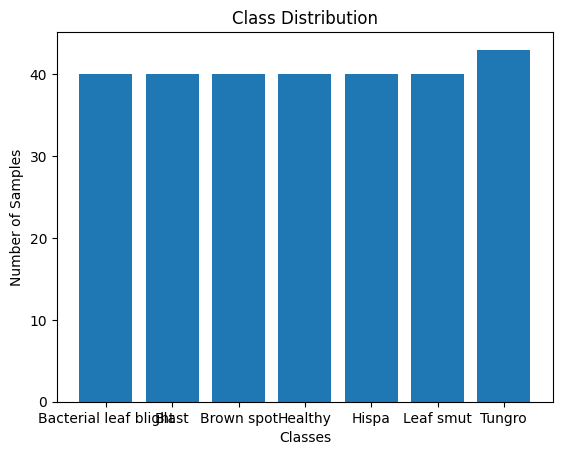

In [37]:
class_counts = {class_name: len(images) for class_name, images in {
    'Bacterial leaf blight': images_var1,
    'Blast': images_var2,
    'Brown spot': images_var3,
    'Healthy': images_var4,
    'Hispa': images_var5,
    'Leaf smut': images_var6,
    'Tungro': images_var7,

}.items()}

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

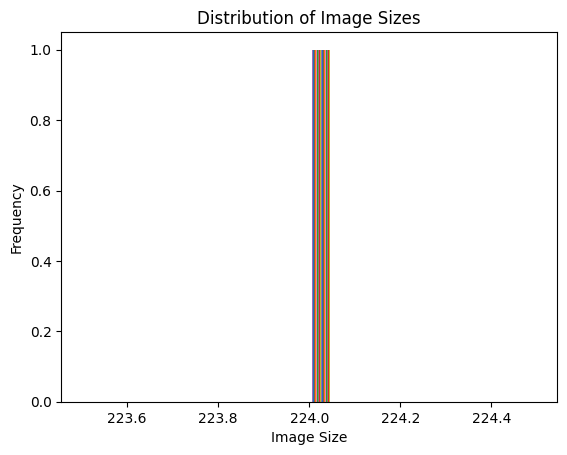

In [39]:
image_sizes = [img.shape[:1] for img in images_var1 + images_var2 + images_var3 + images_var4 + images_var5 + images_var6 + images_var7]

plt.hist(image_sizes, bins=20)
plt.xlabel('Image Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')
plt.show()

In [40]:
no_of_samples = 15

dir1_set = images_var1[:no_of_samples]
dir2_set = images_var2[:no_of_samples]
dir3_set = images_var3[:no_of_samples]
dir4_set = images_var4[:no_of_samples]
dir5_set = images_var5[:no_of_samples]
dir6_set = images_var6[:no_of_samples]
dir7_set = images_var7[:no_of_samples]


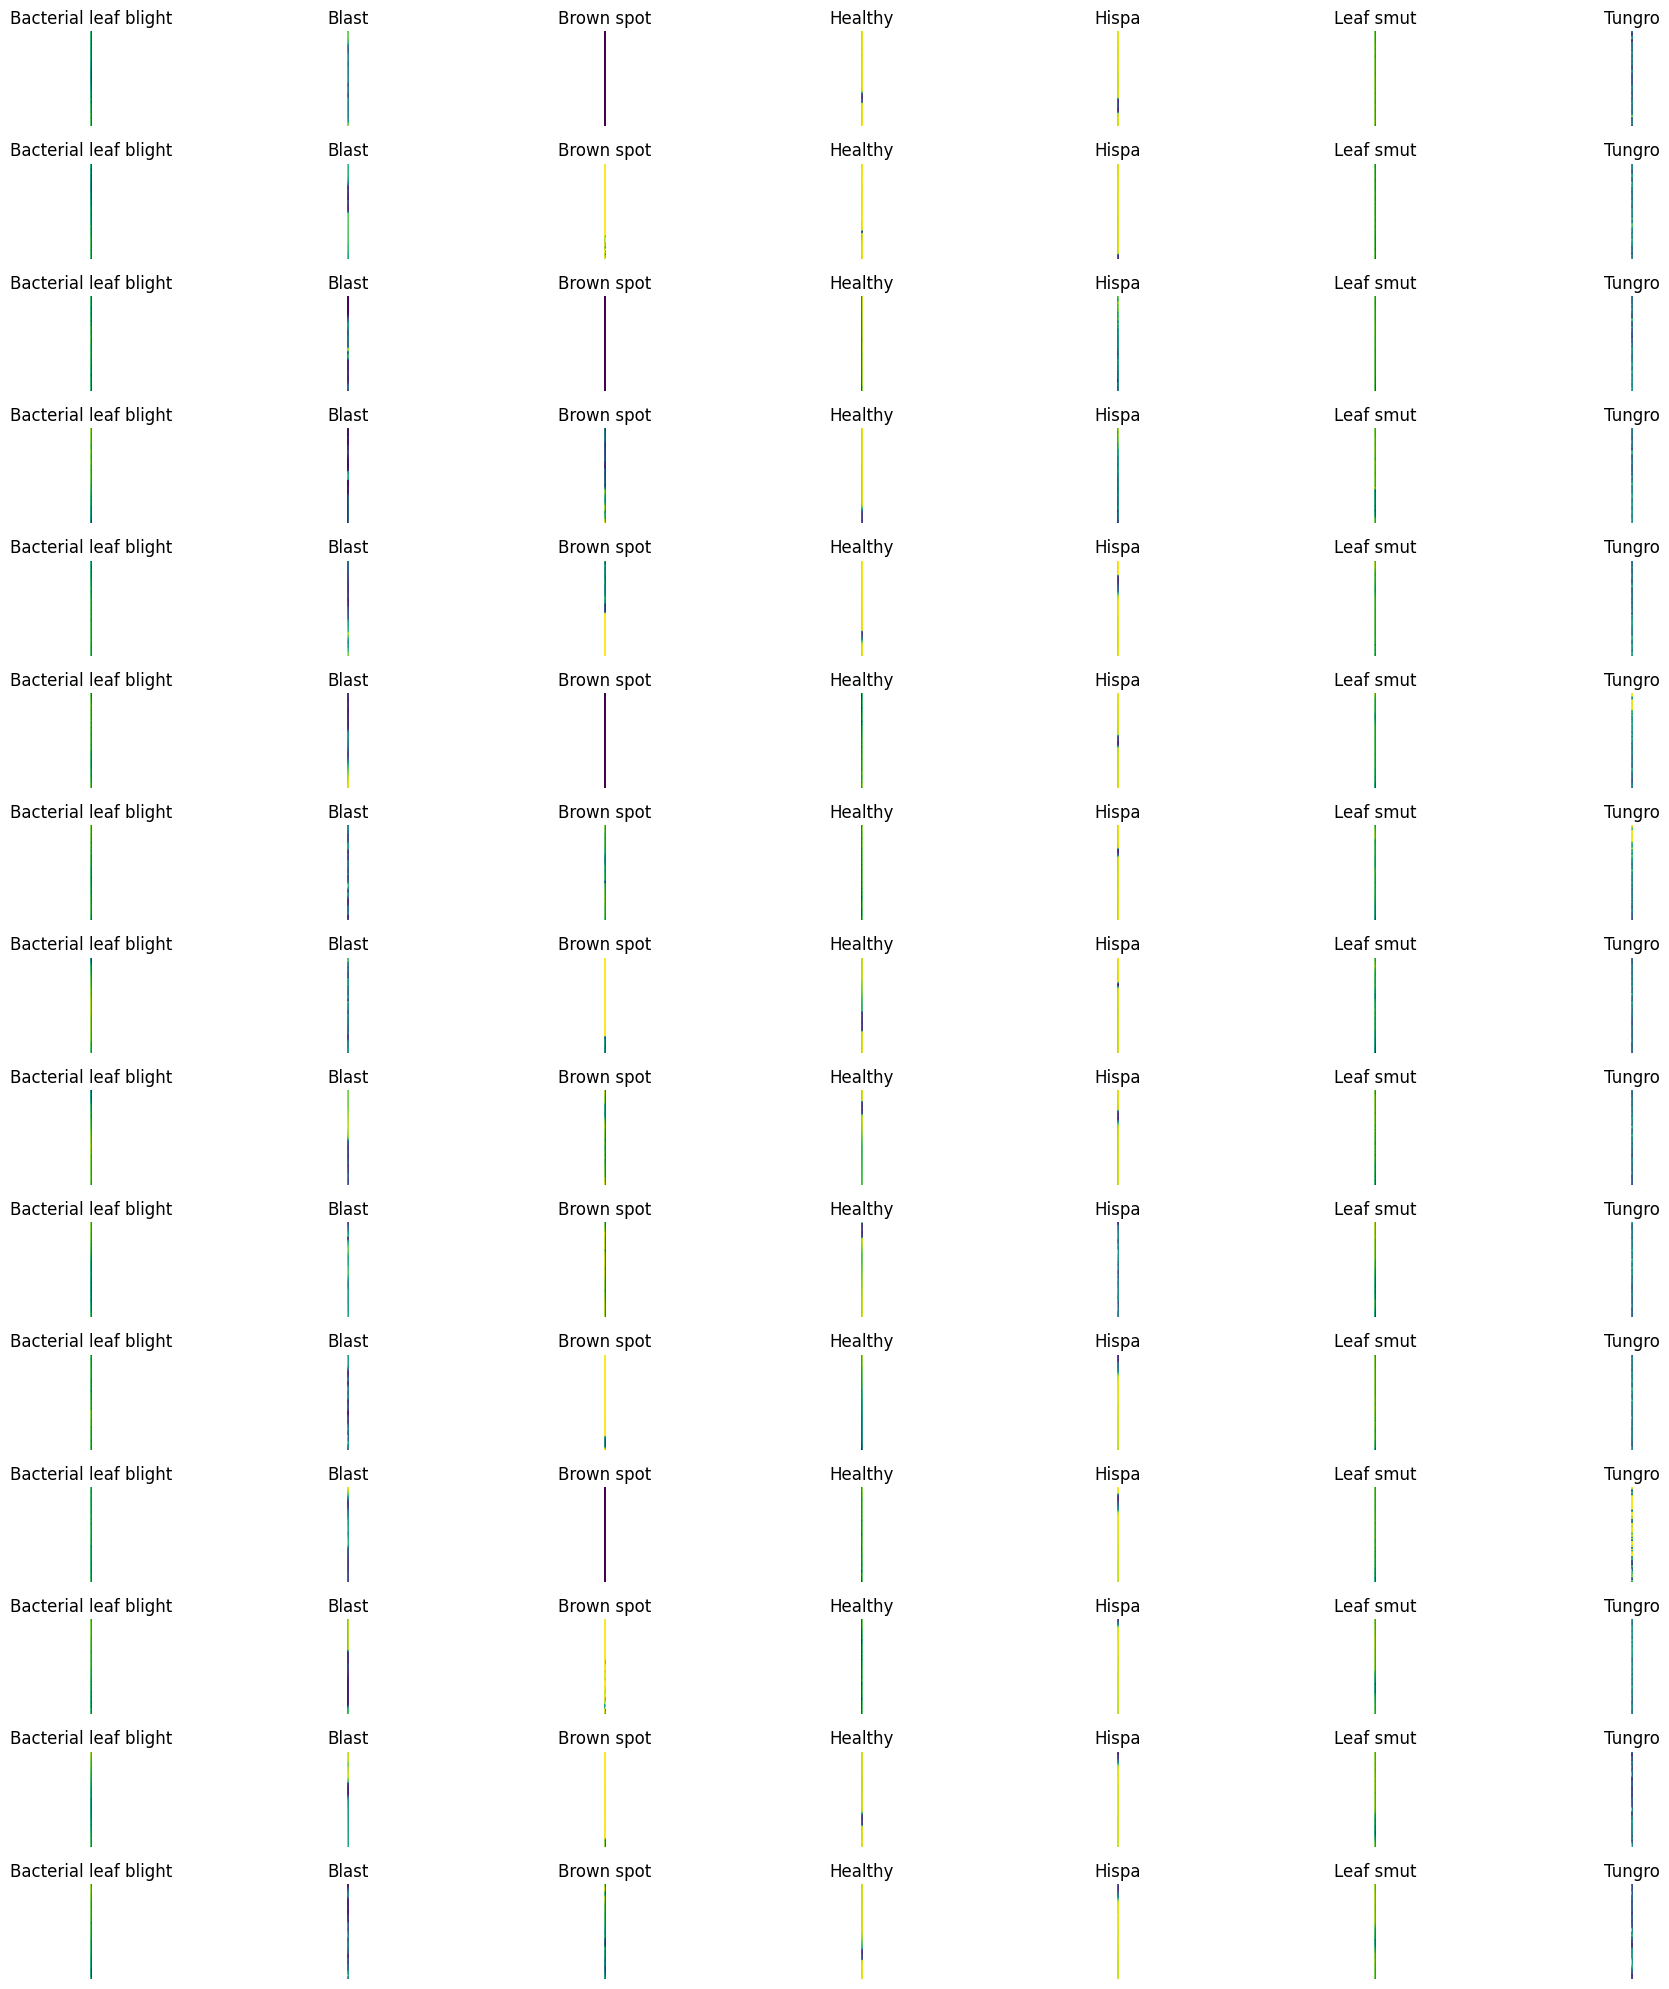

In [42]:
fig, axes = plt.subplots(nrows = no_of_samples, ncols = 7, figsize=(20,20))

for i in range(no_of_samples):
    axes[i,0].imshow(dir1_set[i][0])
    axes[i,0].set_title('Bacterial leaf blight')
    axes[i,0].axis('off')
    
    axes[i,1].imshow(dir2_set[i][0])
    axes[i,1].set_title('Blast')
    axes[i,1].axis('off')
    
    axes[i,2].imshow(dir3_set[i][0])
    axes[i,2].set_title('Brown spot')
    axes[i,2].axis('off')

    axes[i,3].imshow(dir4_set[i][0])
    axes[i,3].set_title('Healthy')
    axes[i,3].axis('off')

    axes[i,4].imshow(dir5_set[i][0])
    axes[i,4].set_title('Hispa')
    axes[i,4].axis('off')

    axes[i,5].imshow(dir6_set[i][0])
    axes[i,5].set_title('Leaf smut')
    axes[i,5].axis('off')

    axes[i,6].imshow(dir7_set[i][0])
    axes[i,6].set_title('Tungro')
    axes[i,6].axis('off')
    
plt.tight_layout()
plt.show()

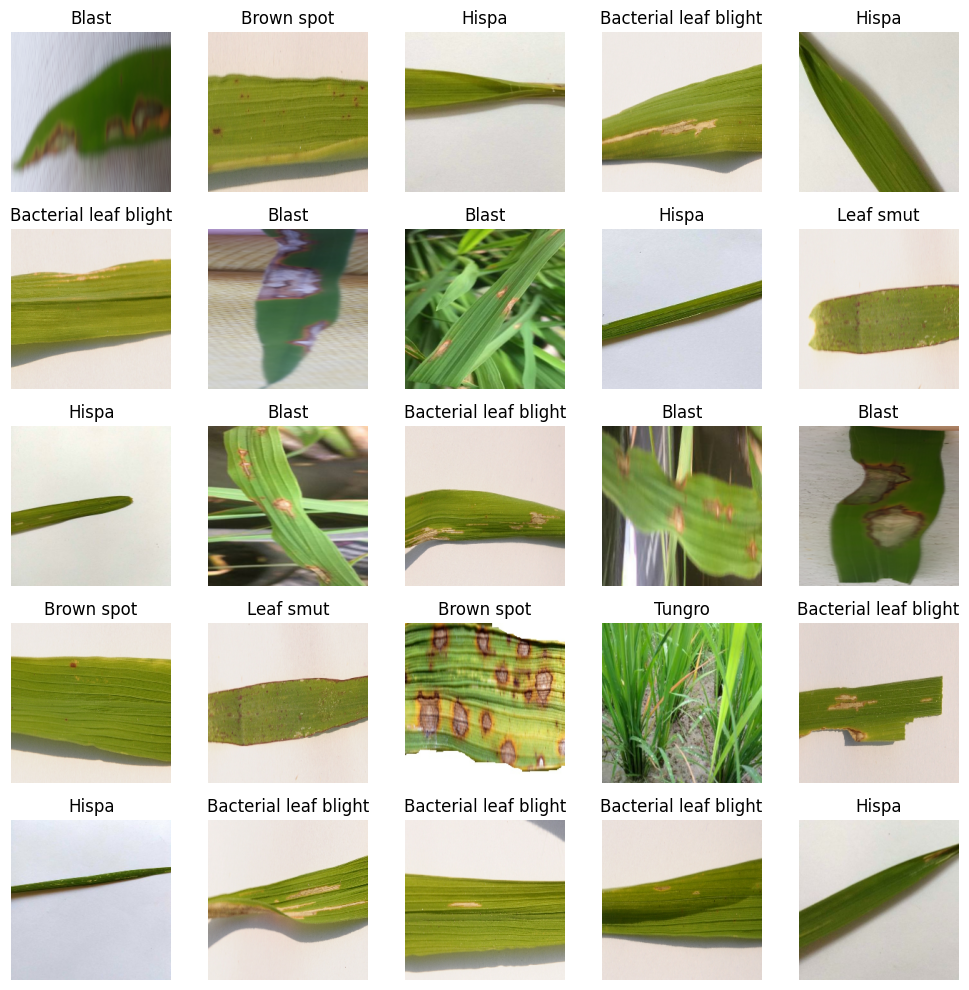

In [43]:
plt.figure(figsize=(10,10))
for images , labels in data.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()

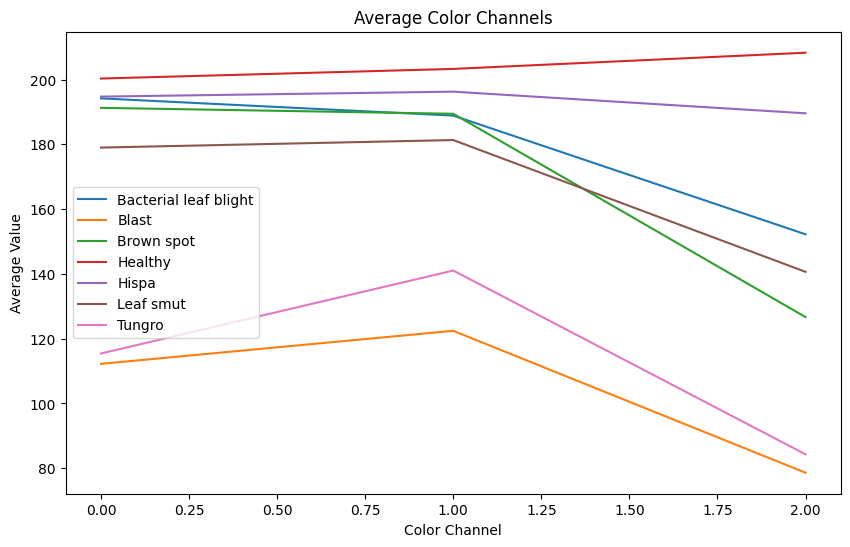

In [45]:
# Calculate average color channels for each class
avg_colors = {}
for class_name, images in {
    'Bacterial leaf blight': images_var1,
    'Blast': images_var2,
    'Brown spot': images_var3,
    'Healthy': images_var4,
    'Hispa': images_var5,
    'Leaf smut': images_var6,
    'Tungro':images_var7

}.items():
    avg_color = np.mean([np.mean(img, axis=(0, 1)) for img in images], axis=0)
    avg_colors[class_name] = avg_color

plt.figure(figsize=(10, 6))
for class_name, avg_color in avg_colors.items():
    plt.plot(avg_color, label=class_name)
plt.xlabel('Color Channel')
plt.ylabel('Average Value')
plt.title('Average Color Channels')
plt.legend()
plt.show()

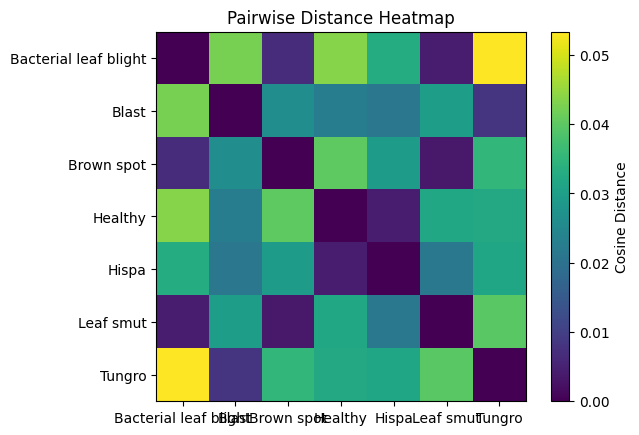

In [48]:
from sklearn.metrics.pairwise import pairwise_distances

class_avg_images = [np.mean([img for img in images], axis=0) for images in [images_var1, images_var2, images_var3,images_var4,images_var5,images_var6,images_var7]]

class_avg_images_reshaped = [avg_img.reshape(-1) for avg_img in class_avg_images]

distances = pairwise_distances(class_avg_images_reshaped, metric='cosine')

plt.imshow(distances, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cosine Distance')
plt.xticks(range(7), ['Bacterial leaf blight', 'Blast', 'Brown spot','Healthy','Hispa','Leaf smut','Tungro'])
plt.yticks(range(7), ['Bacterial leaf blight', 'Blast', 'Brown spot','Healthy','Hispa','Leaf smut','Tungro'])
plt.title('Pairwise Distance Heatmap')
plt.show()

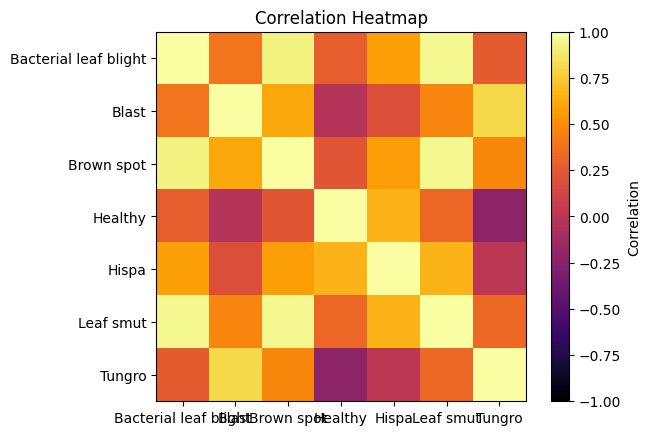

In [49]:

class_avg_images = [np.mean([img for img in images], axis=0) for images in [images_var1, images_var2, images_var3,images_var4,images_var5,images_var6,images_var7]]


class_avg_images_flattened = [avg_img.flatten() for avg_img in class_avg_images]

correlations = np.corrcoef(class_avg_images_flattened)

plt.imshow(correlations, cmap='inferno', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(7), ['Bacterial leaf blight', 'Blast', 'Brown spot','Healthy','Hispa','Leaf smut','Tungro'])
plt.yticks(range(7), ['Bacterial leaf blight', 'Blast', 'Brown spot','Healthy','Hispa','Leaf smut','Tungro'])
plt.title('Correlation Heatmap')
plt.show()

In [50]:
from tensorflow.keras.preprocessing.image import img_to_array

In [55]:
x_image = []
y_label = []

for img in images_var1: 
    x_image.append(img)
    y_label.append('Bacterial leaf blight')
    
for img in images_var2: 
    x_image.append(img)
    y_label.append('Blast')
    
for img in images_var3: 
    x_image.append(img)
    y_label.append('Brown spot')

for img in images_var4: 
    x_image.append(img)
    y_label.append('Healthy')

for img in images_var5: 
    x_image.append(img)
    y_label.append('Hispa')

for img in images_var6: 
    x_image.append(img)
    y_label.append('Leaf smut')
for img in images_var7: 
    x_image.append(img)
    y_label.append('Tungro')

In [56]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [57]:
#converting image and labels to arrays
x_image =np.array(x_image)
y_label = np.array(y_label)

y_encoded = label_encoder.fit_transform(y_label)

In [58]:
x_image.shape

(283, 224, 224, 3)

In [59]:
x_image = x_image / 255.0

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x_image, y_encoded, test_size=0.2, random_state=42)

In [61]:
print(x_train.shape)
print(y_train.shape)

(226, 224, 224, 3)
(226,)


In [64]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  
])

In [65]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [66]:
# model training
# epoch(n) - the training process will iterate through the entire training dataset n number of times, 
            #updating the model's parameters in each iteration.
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# testing the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1376 - loss: 2.8393 - val_accuracy: 0.1739 - val_loss: 1.9223
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.2123 - loss: 1.9081 - val_accuracy: 0.1739 - val_loss: 1.8286
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2764 - loss: 1.8349 - val_accuracy: 0.4130 - val_loss: 1.6346
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3532 - loss: 1.5699 - val_accuracy: 0.4783 - val_loss: 1.2044
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4664 - loss: 1.3285 - val_accuracy: 0.4783 - val_loss: 1.0119
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3970 - loss: 1.3140 - val_accuracy: 0.5870 - val_loss: 0.9455
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4445 - loss: 1.2707 - val_accuracy: 0.5217 - val_loss: 1.0585
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4870 - loss: 1.2052 - val_accuracy: 0.6304 - val_loss: 0.9286
Epoch 9/

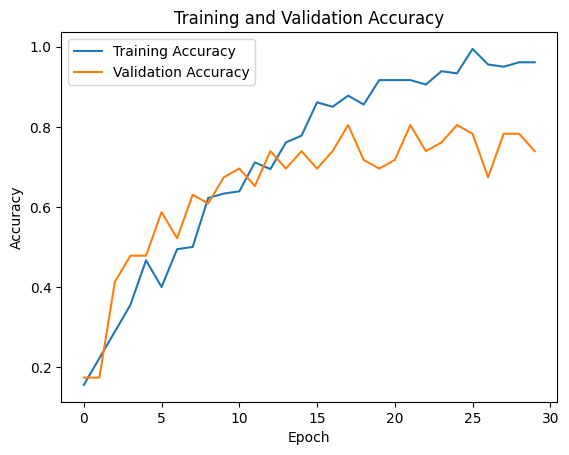

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step


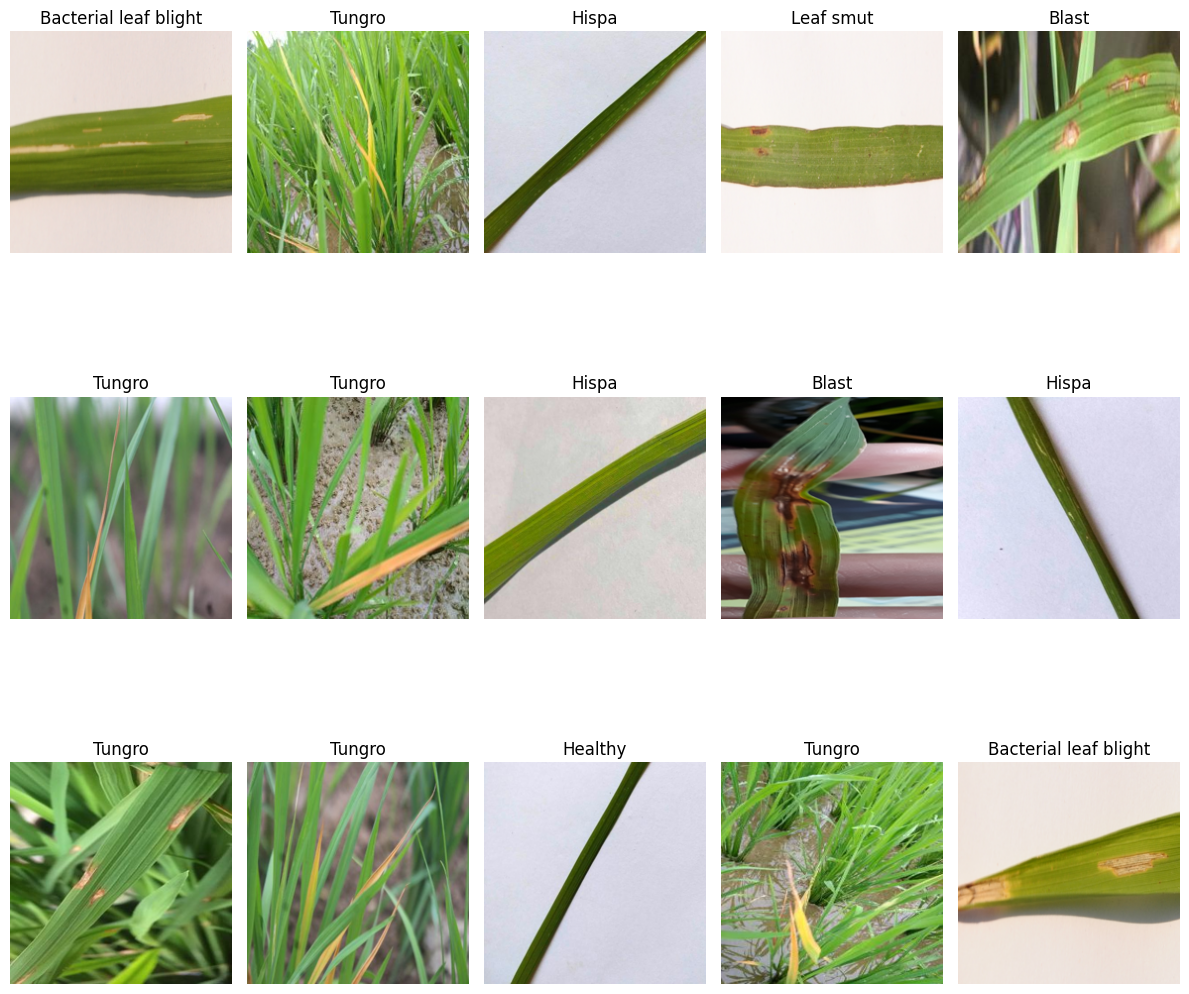

In [67]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

predicted_class_labels = label_encoder.inverse_transform(predicted_labels)

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title(predicted_class_labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [68]:
#hyperparameter tuning -  LEARNING RATE
learning_rate = 0.0001

In [81]:
model_hp = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax') 
])

In [87]:
optimizer = Adam(learning_rate=learning_rate)

In [88]:
model_hp.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [90]:
history = model_hp.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model_hp.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.2003 - loss: 1.9097 - val_accuracy: 0.2391 - val_loss: 1.9056
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.1848 - loss: 1.8884 - val_accuracy: 0.2391 - val_loss: 1.9040
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.2142 - loss: 1.8917 - val_accuracy: 0.2391 - val_loss: 1.9030
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.2188 - loss: 1.8870 - val_accuracy: 0.2609 - val_loss: 1.9026
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.2305 - loss: 1.8885 - val_accuracy: 0.2391 - val_loss: 1.9016
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.2367 - loss: 1.8916 - val_accuracy: 0.2609 - val_loss: 1.9002
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.1738 - loss: 1.8985 - val_accuracy: 0.2391 - val_loss: 1.8989
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.2465 - loss: 1.9003 - val_accuracy: 0.2174 - val_loss: 1.8986
Epoch 9/

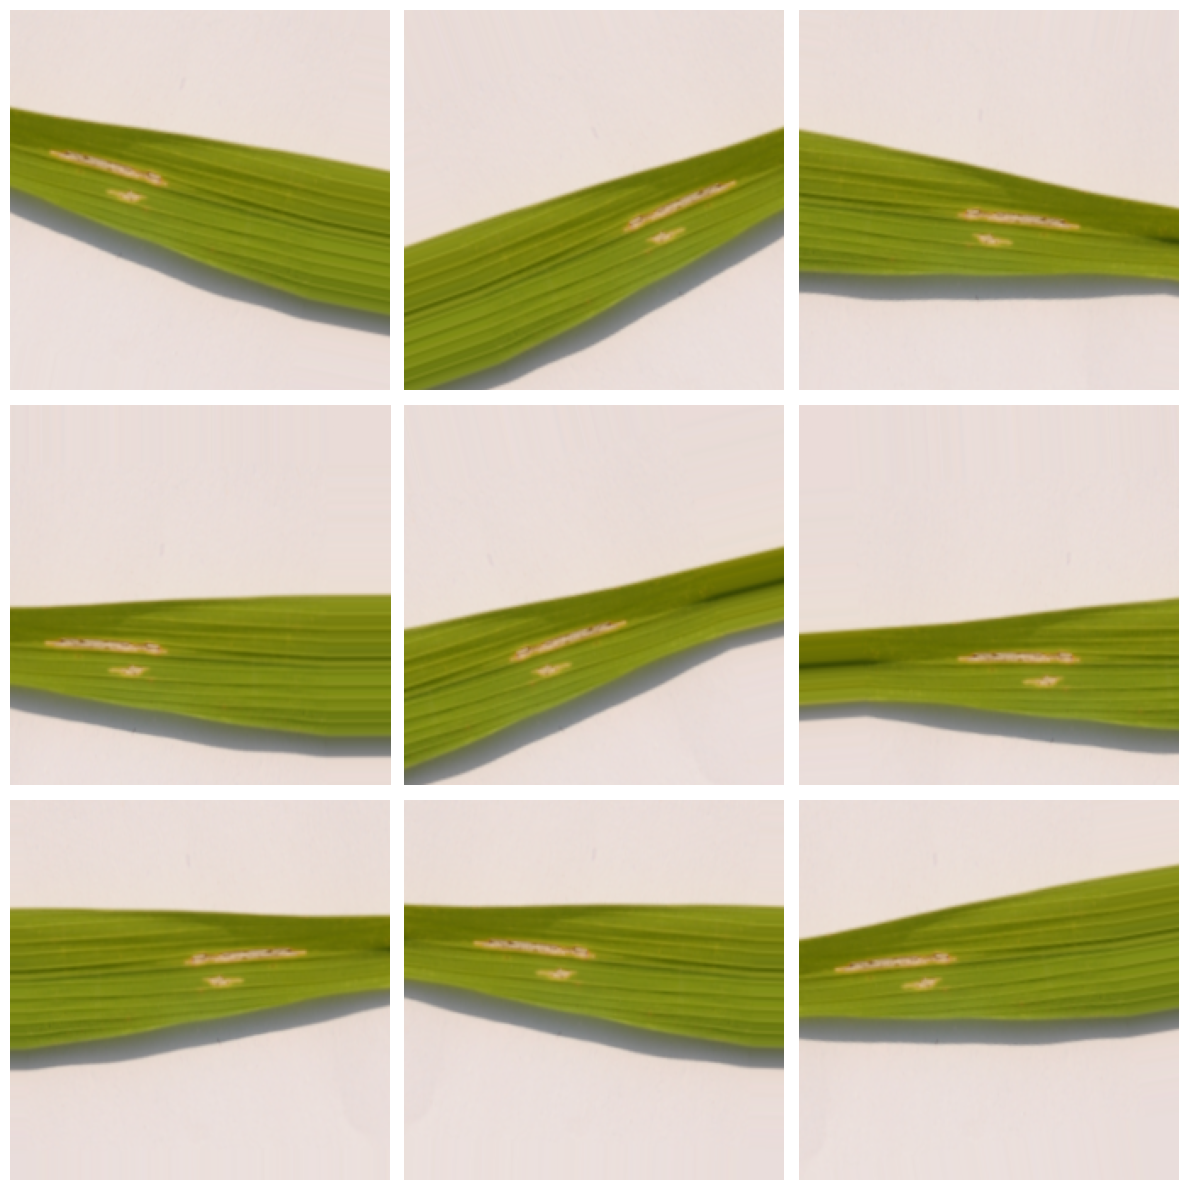

In [73]:
#Visualizing Augmented Images:
# we visualize augmented images to ensure they still represent the original classes. this has to be done in
    #data visualisation section

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

sample_image = x_image[2]
sample_image = np.expand_dims(sample_image, axis=0)

plt.figure(figsize=(12, 12))
for i, augmented_image in enumerate(data_generator.flow(sample_image, batch_size=1)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis('off')
    if i == 8:
        break
plt.tight_layout()
plt.show()

In [74]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [75]:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
#roation_angle - an angle where the image is rotated and the algorithm is run. it goes from -45 to +45(exampe)
#width& height_shift_range - randomly shifting the image horizontally and vertically. This helps the model tolerate small translations in the input data.
#shear_range - maximum range of shear on the axis 
#fill_mode - "nearest," "constant," "reflect," and "wrap."

In [76]:
input_shape = (224, 224, 3)
num_classes = len(label_encoder.classes_)
model_da = create_model(input_shape, num_classes)

In [77]:
augmented_data = datagen.flow(x_train, y_train, batch_size=32)

In [78]:
history = model_da.fit(augmented_data, epochs=30, steps_per_epoch=len(x_train) // 32, validation_data=(x_test, y_test))

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1247 - loss: 3.0801 - val_accuracy: 0.1228 - val_loss: 1.9385
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.1250 - loss: 1.1169 - val_accuracy: 0.1404 - val_loss: 1.9279
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.2006 - loss: 1.9441 - val_accuracy: 0.2632 - val_loss: 1.8785
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.0938 - loss: 1.0753 - val_accuracy: 0.2982 - val_loss: 1.8492
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2896 - loss: 1.8173 - val_accuracy: 0.4561 - val_loss: 1.5520
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.3750 - loss: 0.9106 - val_accuracy: 0.4561 - val_loss: 1.5118
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3630 - loss: 1.5580 - val_accuracy: 0.2456 - val_loss: 1.4993
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.2500 - loss: 0.8849 - val_accuracy: 0.4035 - val_loss: 1.3183
